# Coin Importance Analysis
## By: Carter Carlson

This report analyzes performance of rebalanced and HODL 10-coin portfolios from 7/31/17 to 7/31/18, after 1,000 simulations of randomly-selected portfolios.  All coins used in the analysis had a market cap above \$70,000,000 on 7/31/17, and each portfolio had a starting balance of \$5,000 that was evenly distributed.  

The HODL simulations show portfolio performance over time if the coins are bought and held, while the rebalanced simulations would rebalance portfolios daily based on historical coin prices to evenly distrubute coin weight.

In [49]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ccxt
import os
import seaborn as sns
%matplotlib inline

folder = 'C:/Users/Carter Carlson/Documents/Crypto/backtests/'
historical_data = pd.read_csv(folder + 'historical prices.csv')
coins = historical_data.columns.values[1:]

start_date, end_date = historical_data['date'][0]/1000, historical_data['date'][len(historical_data)-1]/1000
start_date= time.strftime('%m/%d/%Y', time.gmtime(start_date)) 
end_date = time.strftime('%m/%d/%Y', time.gmtime(end_date))

print('Coins used in simulations: {}'.format(coins))

Coins used in simulations: ['BTC' 'ETH' 'XRP' 'LTC' 'DASH' 'XEM' 'ETC' 'XMR' 'NEO' 'ZEC' 'QTUM'
 'STEEM' 'WAVES' 'SC' 'GNO' 'LSK' 'GNT' 'REP' 'DOGE' 'SNT' 'XLM' 'GBYTE'
 'DCR' 'FCT' 'DGB' 'OMG' 'BAT' 'PIVX' 'NXT']

Date range used in simulations: 07/31/2017 - 07/30/2018


In [50]:
hodl_df = pd.read_csv(folder + '10/10_HODL.csv')
rebalanced_df = pd.read_csv(folder + '10/10_rebalanced.csv')

sim_hodl = np.array(hodl_df[hodl_df.columns[1:]])
sim_rebalance = np.array(rebalanced_df[rebalanced_df.columns[1:]])

# Create dataframe with coin names as columns
df = pd.DataFrame(columns=coins)

# Add HODL and rebalance end price as feature
df['end_hodl'] = sim_hodl[len(sim_hodl)-1]
df['end_rebalance'] = sim_rebalance[len(sim_rebalance)-1]
df['performance'] = (df['end_rebalance'] - df['end_hodl'])/df['end_hodl']
df.loc[df['performance'] > 0, 'beat market'] = 1
df.loc[df['performance'] <= 0, 'beat market'] = 0

# Fill in empty columns with 0's
df[coins] = 0

cols = file1.columns.values[1:]
coin_lists = [lst.split('-') for lst in cols]

# Fill in dataframe with coins used for each simulation
for i in range(len(coin_lists)):
    for coin in coin_lists[i]:
        df.loc[i, coin] = 1

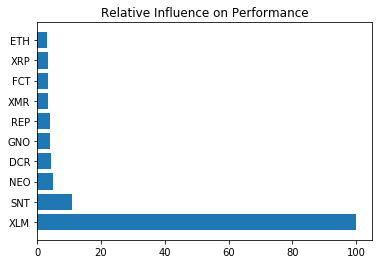

In [53]:
from sklearn.ensemble import RandomForestClassifier

tree = RandomForestClassifier()
X = df[coins]
Y = df['beat market']
tree.fit(X, Y)

# histogram of feature importance
feature_importance = tree.feature_importances_
feature_importance = 100 * (feature_importance / max(feature_importance))
temp = feature_importance.tolist()
top_feats = sorted(feature_importance,reverse=True)[:10]
sorted_features = np.array([temp.index(feat) for feat in top_feats])
pos = np.arange(sorted_features.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_features], align='center')
plt.yticks(pos, X.columns[sorted_features])
plt.title('Relative Influence on Performance')
plt.show()

From this, we can conclude that XLM has the strongest influence for a rebalanced portfolio to overperform or underperform their relative HODL portfolio.  However, we don't know if that influence is a positive factor or a negative factor.

In [54]:
# Make a dataset with XLM and one without - compare performance
xlm_yes = [l for l in cols if 'XLM' in l]
xlm_no = [l for l in cols if 'XLM' not in l]

file3 = pd.read_csv(folder + '10/10_summary.csv')

xlm_yes_df = file3.loc[file3['portfolio'].isin(xlm_yes)]
xlm_no_df = file3.loc[file3['portfolio'].isin(xlm_no)]

for a in [xlm_yes_df, xlm_no_df]:
    diffs = a['end_price_rebalanced'] - a['end_price_HODL']
    pos_returns = diffs[diffs>0]
    neg_returns = diffs[diffs<0]

    return_vs_hodl = diffs.mean() / a['end_price_HODL'].mean()

    print('\nAverage hodl result: ', round(a['end_price_HODL'].mean(), 2))
    print('Average rebalanced result: ', round(a['end_price_rebalanced'].mean(), 2))
    print('# rebalance sims that outperformed: ', len(pos_returns))
    print('# rebalance sims that underperformed: ', len(neg_returns))
    print('Percent of rebalance sims to outperform HODL: ', round((len(pos_returns)/(len(pos_returns) + len(neg_returns))),2))


Average hodl result:  18558.72
Average rebalanced result:  14803.16
# rebalance sims that outperformed:  59
# rebalance sims that underperformed:  311
Percent of rebalance sims to outperform HODL:  0.16

Average hodl result:  9910.89
Average rebalanced result:  17355.13
# rebalance sims that outperformed:  622
# rebalance sims that underperformed:  8
Percent of rebalance sims to outperform HODL:  0.99


### Conclusion
After comparing simulated portolios with XLM to simulated portfolios without XLM, I found that:

* Rebalanced portfolios with XLM are most likely to underperform the respective HODL portfolio.

* Rebalanced portfolios without XLM, on average, outperformed rebalanced portfolios with XLM.

* Rebalancing a portfolio with XLM will only outperform their HODL counterport 16% of the time, while rebalancing a portfolio without XLM will outperform HODL 99% of the time.